In [1]:
import ROOT
from hep_utils.constants import N_RINGS, RINGS_LAYERS
from hep_utils.root import get_column_names, rdf_to_pandas
from hep_utils import formulas
import hep_utils.plotting.pyplot as hplt
import mplhep as hep
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np
import os
ROOT.EnableImplicitMT()
plt.style.use(hep.style.ROOT)

Module libc not found.


Welcome to JupyROOT 6.28/02


In [2]:
dataset_dir = '/root/data/2024_08_05_18_40_1722897640_overlapping_zee'
output_dir = os.path.join(dataset_dir, 'plots')
os.makedirs(output_dir, exist_ok=True)
ntuple_filepath = os.path.join(dataset_dir,
                               'NTUPLE',
                               'overlapping_zee.NTUPLE.root')
ntuple_rdf = ROOT.RDataFrame('events', ntuple_filepath)
rings_cols = []
for i in range(N_RINGS):
    rings_col_str = f'rings_{i}'
    ntuple_rdf = ntuple_rdf.Define(rings_col_str, f'rings[{i}]')
    rings_cols.append(rings_col_str)
column_names = get_column_names(ntuple_rdf)
ntuple_pdf = rdf_to_pandas(ntuple_rdf, [name for name in column_names if name != 'rings'], nrows=-1)
print(f"DataFrame shape: {ntuple_pdf.shape}")
ntuple_pdf.head()

DataFrame shape: (15375, 147)


,cluster_deta,cluster_dphi,cluster_e,cluster_e0,cluster_e1,cluster_e2,cluster_e233,cluster_e237,cluster_e277,cluster_e2tsts1,...,rings_90,rings_91,rings_92,rings_93,rings_94,rings_95,rings_96,rings_97,rings_98,rings_99
0,0.2,0.2,44439.867188,-316.698120,32497.556641,12151.442383,11428.733398,12130.144531,12813.404297,5604.663086,...,0.665863,0.0,83.021767,-182.681015,-309.305328,-285.991669,116.981964,-28.657433,-260.542480,-165.04454
1,0.2,0.2,37840.414062,-628.925171,25823.501953,12710.341797,9137.831055,9932.454102,11066.757812,3031.091064,...,0.665863,0.0,83.021767,-182.681015,-309.305328,-285.991669,116.981964,-28.657433,-260.542480,-165.04454
2,0.2,0.2,184191.765625,15.404839,90481.375000,94295.359375,51769.050781,53184.808594,54069.984375,17331.470703,...,0.000000,0.0,52.072205,-36.125046,-18.187490,0.000000,0.000000,0.000000,0.000000,0.00000
3,0.2,0.2,109545.062500,1067.934814,39279.910156,370.384613,492.820801,722.312866,631.919800,3238.802734,...,0.000000,0.0,52.072205,-36.125046,-18.187490,0.000000,0.000000,0.000000,0.000000,0.00000
4,0.2,0.2,59975.304688,22.969753,28706.312500,30881.144531,28242.474609,29276.109375,30572.699219,4400.982422,...,9.784944,0.0,26.154953,-48.329182,-7.376780,0.000000,17.030565,-22.150364,0.802311,0.00000


In [3]:
def ntuple_aggregation(df: pd.DataFrame) -> pd.Series:
    n_objects = len(df)
    if n_objects:
        ordered_idxs = df.index[df['cluster_e'].argsort()][::-1]
        highest_e1 = df.loc[ordered_idxs[0], 'cluster_e']
        highest_e2 = df.loc[ordered_idxs[1], 'cluster_e'] if n_objects > 1 else np.nan
        eta1 = df.loc[ordered_idxs[0], 'el_eta']
        eta2 = df.loc[ordered_idxs[1], 'el_eta'] if n_objects > 1 else np.nan
        phi1 = df.loc[ordered_idxs[0], 'el_phi']
        phi2 = df.loc[ordered_idxs[1], 'el_phi'] if n_objects > 1 else np.nan
    else:
        highest_e1 = np.nan
        highest_e2 = np.nan
        eta1 = np.nan
        eta2 = np.nan
        phi1 = np.nan
        phi2 = np.nan
    return pd.Series({
        'n_objects': n_objects,
        'n_duplicates': df.duplicated().sum(),
        'highest_e1': highest_e1,
        'highest_e2': highest_e2,
        'eta1': eta1,
        'eta2': eta2,
        'phi1': phi1,
        'phi2': phi2
    })
ntuple_grouped_clusters = ntuple_pdf.groupby('event_number').apply(ntuple_aggregation)
ntuple_grouped_clusters.head()

,n_objects,n_duplicates,highest_e1,highest_e2,eta1,eta2,phi1,phi2
event_number,,,,,,,,
0,2.0,0.0,44439.867188,37840.414062,1.6255,-1.2625,1.9513,-1.1903
1,2.0,0.0,184191.765625,109545.062500,-0.6625,1.3875,-2.9820,0.1473
2,2.0,0.0,59975.304688,38481.160156,-1.0375,0.0375,-0.4540,2.7121
3,2.0,0.0,138957.484375,37300.324219,-2.0505,-0.5625,0.2332,3.0312
4,2.0,0.0,62486.160156,37017.023438,1.4625,-0.1375,2.1476,-1.3131


In [4]:
ntuple_grouped_clusters['deltaR'] = formulas.deltaR(ntuple_grouped_clusters['eta1'].values,
                                                    ntuple_grouped_clusters['eta2'].values,
                                                    ntuple_grouped_clusters['phi1'].values,
                                                    ntuple_grouped_clusters['phi2'].values)
print(f"DataFrame shape: {ntuple_grouped_clusters.shape}")
ntuple_grouped_clusters.head()

DataFrame shape: (9992, 9)


,n_objects,n_duplicates,highest_e1,highest_e2,eta1,eta2,phi1,phi2,deltaR
event_number,,,,,,,,,
0,2.0,0.0,44439.867188,37840.414062,1.6255,-1.2625,1.9513,1.2625,1.303860
1,2.0,0.0,184191.765625,109545.062500,-0.6625,1.3875,-2.9820,1.3875,2.702820
2,2.0,0.0,59975.304688,38481.160156,-1.0375,0.0375,-0.4540,0.0375,0.584704
3,2.0,0.0,138957.484375,37300.324219,-2.0505,-0.5625,0.2332,0.5625,2.351955
4,2.0,0.0,62486.160156,37017.023438,1.4625,-0.1375,2.1476,0.1375,0.698762


# Plots

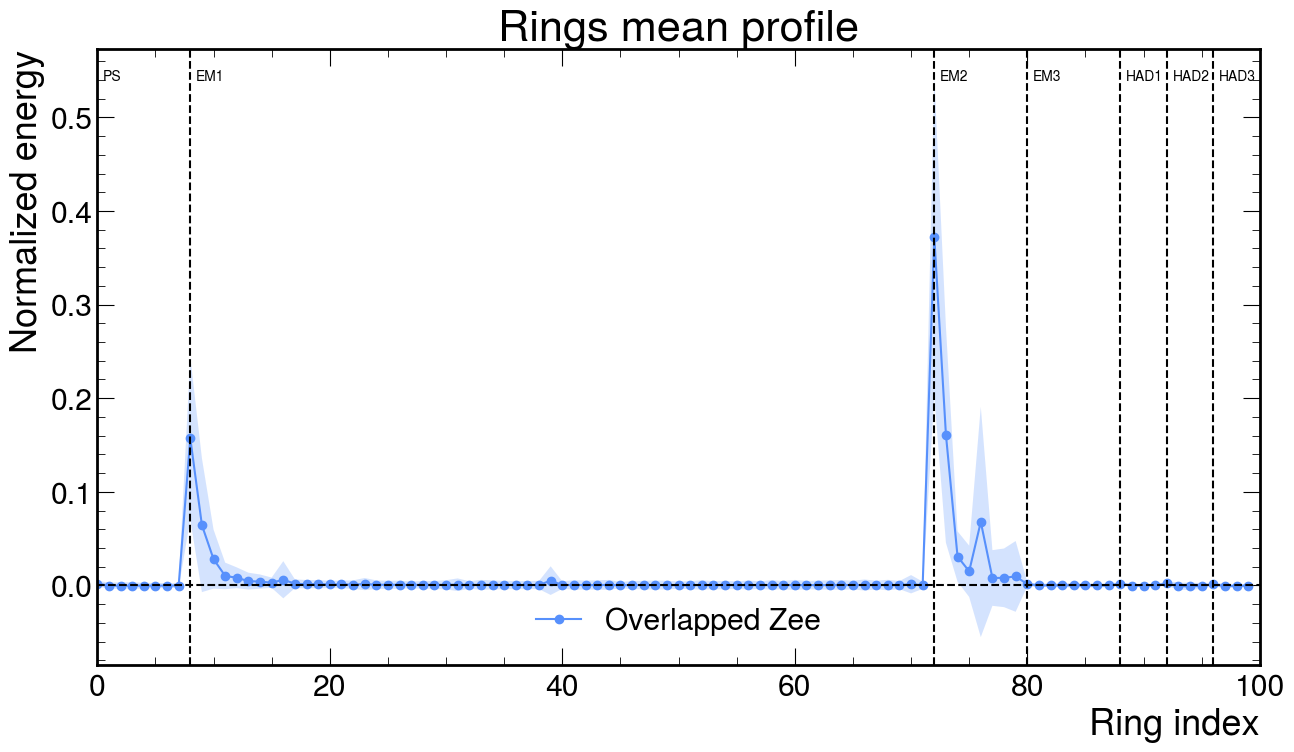

In [5]:
fig, ax = plt.subplots(figsize=(15, 8))
hplt.plot_rings_profile(ntuple_pdf[rings_cols], ax, normalize=True)
fig.savefig(os.path.join(output_dir, 'rings_profile.png'), bbox_inches='tight', dpi=300)
fig.savefig(os.path.join(output_dir, 'rings_profile.pdf'), bbox_inches='tight')

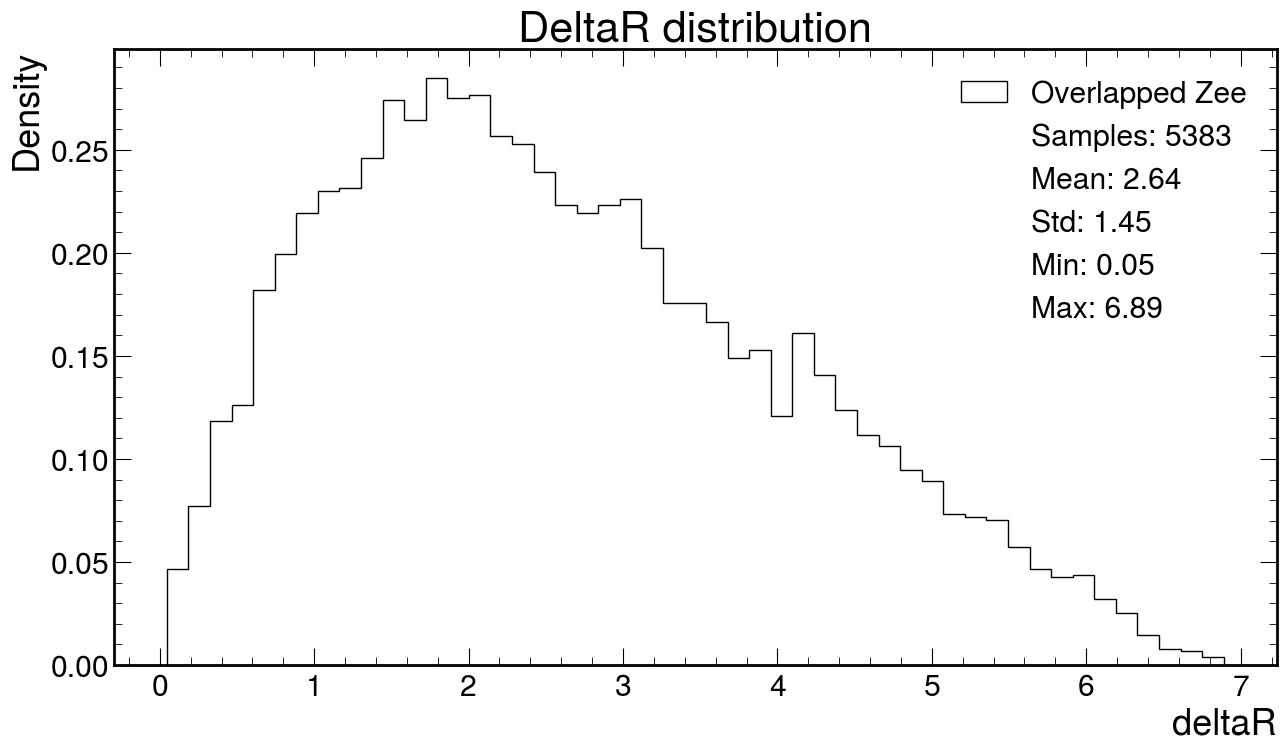

In [6]:
fig, ax = plt.subplots(figsize=(15, 8))
hplt.histplot(
    ntuple_grouped_clusters['deltaR'].dropna(),
    nbins=50,
    ax=ax,
    metrics=True,
    ax_set=dict(
        xlabel='deltaR',
        ylabel='Density',
        title='DeltaR distribution',
    ),
    hist_kwargs=dict(
        histtype='step',
        label='Overlapped Zee',
        color='k',
        density=True
    )
)
fig.savefig(os.path.join(output_dir, 'deltaR_distribution.png'), bbox_inches='tight', dpi=300)
fig.savefig(os.path.join(output_dir, 'deltaR_distribution.pdf'), bbox_inches='tight')

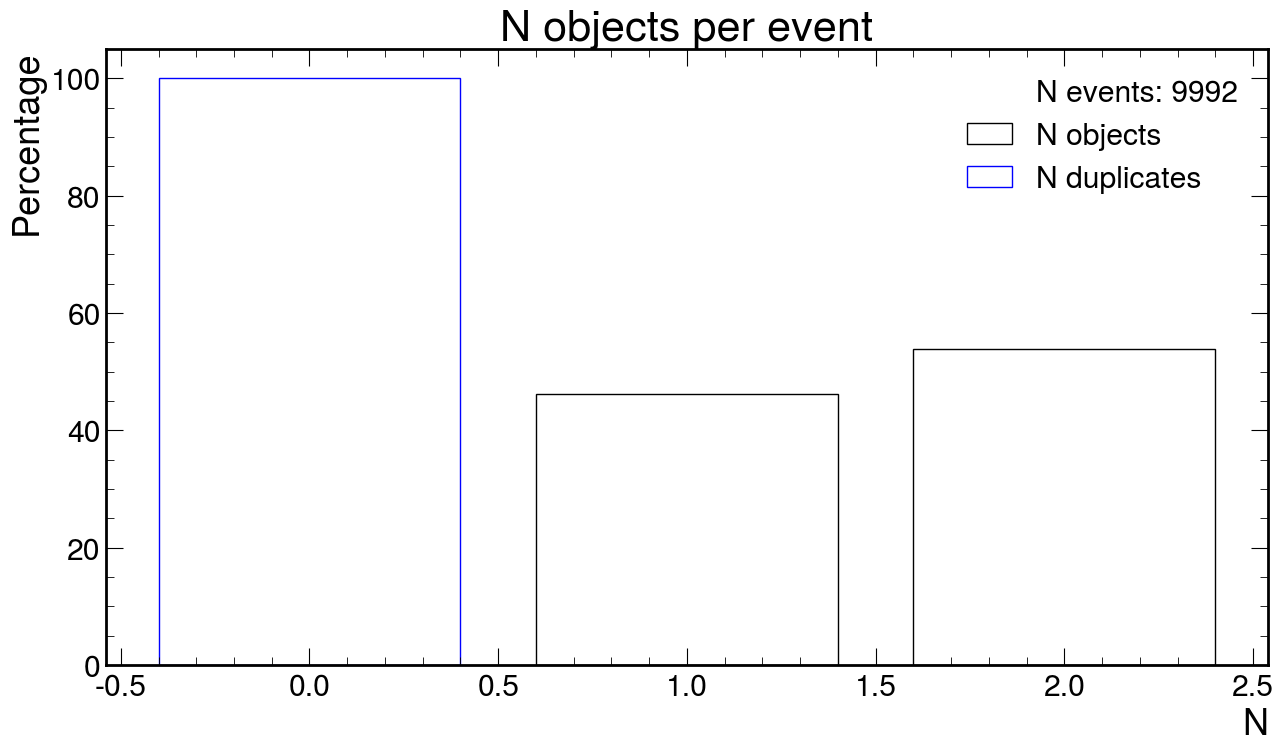

In [7]:
fig, ax = plt.subplots(figsize=(15, 8))
hplt.categorical_histplot(
    ntuple_grouped_clusters['n_objects'].dropna(),
    ax=ax,
    metrics=False,
    percentage=True,
    ax_set=dict(
        xlabel='N',
        ylabel='Percentage',
        title='N objects per event',
    ),
    bar_kwargs=dict(
        label='N objects',
        color='w',
        edgecolor='k'
    )
)
hplt.categorical_histplot(
    ntuple_grouped_clusters['n_duplicates'].dropna(),
    ax=ax,
    metrics=False,
    ax_set=dict(),
    percentage=True,
    bar_kwargs=dict(
        label='N duplicates',
        color='w',
        edgecolor='b'
    )
)
ax.plot([], [], ' ', label=f"N events: {len(ntuple_grouped_clusters)}")
ax.legend()
fig.savefig(os.path.join(output_dir, 'objects_per_event_distribution.png'), bbox_inches='tight', dpi=300)
fig.savefig(os.path.join(output_dir, 'objects_per_event_distribution.pdf'), bbox_inches='tight')

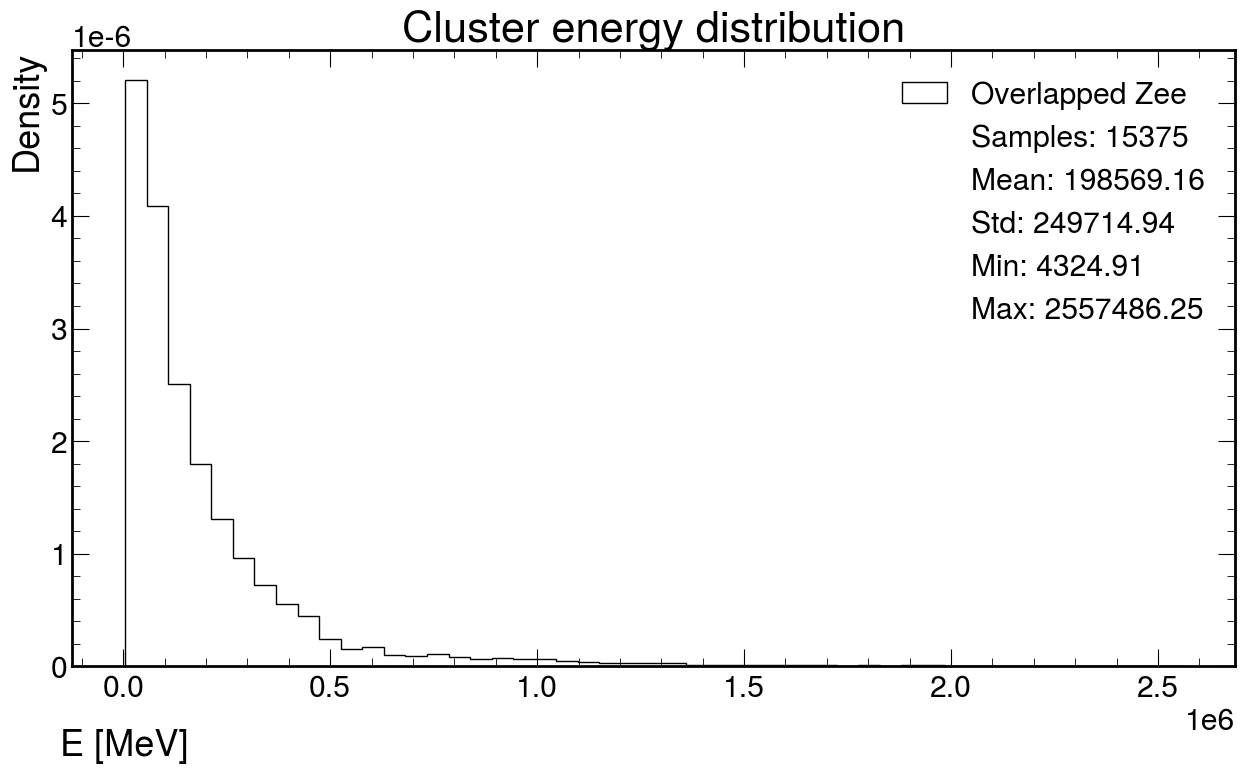

In [8]:
fig, ax = plt.subplots(figsize=(15, 8))
hplt.histplot(
    ntuple_pdf['cluster_e'].dropna(),
    nbins=50,
    ax=ax,
    metrics=True,
    ax_set=dict(
        xlabel='E [MeV]',
        ylabel='Density',
        title='Cluster energy distribution',
    ),
    hist_kwargs=dict(
        histtype='step',
        label='Overlapped Zee',
        color='k',
        density=True
    )
)
ax.xaxis.set_label_coords(0.1, -0.1)
fig.savefig(os.path.join(output_dir, 'cluster_e_distribution.png'), bbox_inches='tight', dpi=300)
fig.savefig(os.path.join(output_dir, 'cluster_e_distribution.pdf'), bbox_inches='tight')